In [1]:
import os

# Set the number of threads for all relevant libraries
num_threads = "8"
os.environ["OMP_NUM_THREADS"] = num_threads
os.environ["OPENBLAS_NUM_THREADS"] = num_threads
os.environ["MKL_NUM_THREADS"] = num_threads
os.environ["VECLIB_MAXIMUM_THREADS"] = num_threads
os.environ["NUMEXPR_NUM_THREADS"] = num_threads

import torch
import numpy as np
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device}")

if device.type == 'cpu':
    torch.set_num_threads(8)
    print(f"Limiting cpu threads to: {torch.get_num_threads()}")

Using cpu
Limiting cpu threads to: 8


In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Real Beam Params
L_real = 5.0      # Beam length (m)
W_real = 1.0      # Beam width (m)
H_real = 1.0      # Beam height (m)

# 3D problems use fundamental material properties E and nu, not the composite EI.
# We can derive E from your old EI value for consistency.
# For a rectangular cross-section, I = (width * height^3) / 12

EI_real = 135245
I = (W_real * H_real**3) / 12.0  # Moment of Inertia
E_real = EI_real / I             # E = EI / I -> 135245 / (1/12) = 1,622,940 Pa
nu_real = 0.3                    # Poisson's Ratio (a material property, 0.3 is common)

# Force magnitudes remain the same
P_tip_real = 500  # N
P_mid_real = 300  # N

# Normalisation
L_characteristic = L_real

L_norm = L_real / L_characteristic # = 1.0
W_norm = W_real / L_characteristic # = 0.2
H_norm = H_real / L_characteristic # = 0.2
P_characteristic = P_tip_real

P_tip_norm = P_tip_real / P_characteristic
P_mid_norm = P_mid_real / P_characteristic

E_norm = E_real / (P_characteristic / L_real**2)
nu_norm = nu_real

x_scale = L_real
w_scale = (P_characteristic * L_real**3) / EI_real

# Define Neural Network
class PINN_Cantilever(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            #nn.Linear(64, 64),
            #nn.Tanh(),
            #nn.Linear(64, 64),
            #nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 3)
        )

    def forward(self, x):
        #nn_output = self.net(x)
        #final_displacement = (x**2) * nn_output

        return self.net(x) #final_displacement

In [3]:
# 3d problem only requires first derivative
def get_gradient(y, x):
    """Computes the gradient of y (N, 3) with respect to x (N, 3)."""
    # We need to compute the gradient of each output component (u, v, w) separately
    grad_u = torch.autograd.grad(y[:, 0], x, grad_outputs=torch.ones_like(y[:, 0]), create_graph=True)[0]
    grad_v = torch.autograd.grad(y[:, 1], x, grad_outputs=torch.ones_like(y[:, 1]), create_graph=True)[0]
    grad_w = torch.autograd.grad(y[:, 2], x, grad_outputs=torch.ones_like(y[:, 2]), create_graph=True)[0]
    
    # Stack them to form the full gradient tensor of shape [N, 3, 3]
    # where grad[i, j, k] = d(u_j)/d(x_k) for the i-th point
    return torch.stack([grad_u, grad_v, grad_w], dim=1)

# Loss Function
def loss_fn_strainenergy(model, x_interior, x_forces, P_forces, x_boundary, E, nu):
#====================================================================================
    # 1. Strain Energy (U) - Energy stored in the bent beam
#====================================================================================

    x_interior.requires_grad = True
    u_interior = model(x_interior)

    # Calculate the 3x3 displacement gradient tensor (du/dx)
    grad_u = get_gradient(u_interior, x_interior) # Shape: [N, 3, 3]

    # Calculate the 6 unique components of the symmetric strain tensor (ε = 0.5 * (∇u + (∇u)^T))
    epsilon_xx = grad_u[:, 0, 0]
    epsilon_yy = grad_u[:, 1, 1]
         # e.g. ^ "for all N point indices, y component of displacement (v), derivative wrt y"
    epsilon_zz = grad_u[:, 2, 2]
    epsilon_xy = 0.5 * (grad_u[:, 0, 1] + grad_u[:, 1, 0])
    epsilon_xz = 0.5 * (grad_u[:, 0, 2] + grad_u[:, 2, 0])
    epsilon_yz = 0.5 * (grad_u[:, 1, 2] + grad_u[:, 2, 1])

    #Calculate the 6 unique components of the stress tensor (σ) using Hooke's Law
    # First, calculate Lamé parameters from E and nu
    # -->> Lame params make the maths simpler (more simple than youngs mod E and poisson ratio nu)
    lmbda = (E * nu) / ((1 + nu) * (1 - 2 * nu))
    mu = E / (2 * (1 + nu))

    # Volumetric strain (calculated as the trace of the strain tensor)
    tr_epsilon = epsilon_xx + epsilon_yy + epsilon_zz

    sigma_xx = lmbda * tr_epsilon + 2 * mu * epsilon_xx
    sigma_yy = lmbda * tr_epsilon + 2 * mu * epsilon_yy
    sigma_zz = lmbda * tr_epsilon + 2 * mu * epsilon_zz
    sigma_xy = 2 * mu * epsilon_xy
    sigma_xz = 2 * mu * epsilon_xz
    sigma_yz = 2 * mu * epsilon_yz

    # Calculate strain energy density (uses the stress tensor, σ)
    #------------------------------------------------------------------

    #SED = 0.5 * (σ : ε), : is the double dot product
    strain_energy_density = 0.5 * (
        sigma_xx * epsilon_xx + sigma_yy * epsilon_yy + sigma_zz * epsilon_zz +
        2 * (sigma_xy * epsilon_xy + sigma_xz * epsilon_xz + sigma_yz * epsilon_yz)
    )

    #Total Strain Energy (U) is the integral (mean) of the density over the volume
    # Assuming the volume of the domain is V = L*W*H. For a 2x1x1 beam, V=2.
    # If using a normalized domain of 1x1x1, V=1.
    domain_volume = L_real * H_real * W_real 
    strain_energy = torch.mean(strain_energy_density) * domain_volume

    return strain_energy

    #=======================================================================================
    #=======================================================================================

    # 2. Work Potential (W) - Work done by external forces

def loss_fn_work(model, x_forces, P_forces):
    u_at_forces = model(x_forces)  #[num_forces, 3]
    # -->> Sum of dot products: Σ (P_i · u_i)
    work_potential = torch.sum(P_forces * u_at_forces)

    return work_potential

    # 3. Boundary Conditions (BCs) at the fixed wall

def loss_fn_bc(model, x_interior, x_forces, P_forces, x_boundary, E, nu):
    u_boundary = model(x_boundary)
    loss_displacement = torch.mean(u_boundary.pow(2))

    grad_u_boundary = get_gradient(u_boundary, x_boundary)
    loss_slope = torch.mean(grad_u_boundary.pow(2))

    loss_bc = loss_displacement + loss_slope

    return loss_bc

    # 4. Total Loss
    # The total loss is the potential energy of the system plus the BC penalty.
    #+ 5e4 * loss_bc

In [4]:
# Initialize
model = PINN_Cantilever()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)



# Training Data (normalized domain)

num_interior_points = 5000
x_interior = torch.rand(num_interior_points, 3)
x_interior *= torch.tensor([L_norm, W_norm, H_norm])
x_interior.requires_grad = True

# Boundary Points 
num_boundary_points = 1000
x_boundary = torch.rand(num_boundary_points, 3)
x_boundary[:, 0] = 0.0 # Set x-coordinate to 0
x_boundary[:, 1] *= W_norm
x_boundary[:, 2] *= H_norm
x_boundary.requires_grad = True

# Force Tensors
x_forces = torch.tensor([
    [L_norm / 2, W_norm / 2, H_norm / 2], # Midpoint force location
    [L_norm, W_norm / 2, H_norm / 2]
])

P_forces = torch.tensor([
    [0.0, 0.0, -P_mid_norm], # Midpoint force vector
    [0.0, 0.0, -P_tip_norm]  # Tip force vector
])

# Pre-Training Loop
#for epoch in range(1000):
 #   optimizer.zero_grad()
  #  #loss = loss_fn_strainenergy(model, x_interior, x_forces, P_forces, x_boundary, E_norm, nu_norm)
   # loss = loss_fn_work(model, x_forces, P_forces)
    #loss += loss_fn_bc(model, x_interior, x_forces, P_forces, x_boundary, E_norm, nu_norm)
    #loss.backward()
    #optimizer.step()
    #if epoch % 100 == 0:
     #   print(f"Epoch {epoch}, Loss = {loss.item():.6f}")

for epoch in range(10000):
    optimizer.zero_grad()
    loss = loss_fn_strainenergy(model, x_interior, x_forces, P_forces, x_boundary, E_norm, nu_norm)
    loss += 1550 * loss_fn_work(model, x_forces, P_forces)
    loss += 1e6 * loss_fn_bc(model, x_interior, x_forces, P_forces, x_boundary, E_norm, nu_norm)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss = {loss.item():.6f}")



Epoch 0, Loss = 10199.616211
Epoch 100, Loss = -11.581680
Epoch 200, Loss = -18.086126
Epoch 300, Loss = -24.856268
Epoch 400, Loss = -34.888927
Epoch 500, Loss = -60.146690
Epoch 600, Loss = -135.806778
Epoch 700, Loss = -209.909729
Epoch 800, Loss = -244.535095
Epoch 900, Loss = -273.455017
Epoch 1000, Loss = -300.342010
Epoch 1100, Loss = -320.879974
Epoch 1200, Loss = -330.583008
Epoch 1300, Loss = -331.495819
Epoch 1400, Loss = -340.377289
Epoch 1500, Loss = -340.189362
Epoch 1600, Loss = -344.746338
Epoch 1700, Loss = -345.940521
Epoch 1800, Loss = -346.934021
Epoch 1900, Loss = -347.754059
Epoch 2000, Loss = -349.703186
Epoch 2100, Loss = -350.561951
Epoch 2200, Loss = -344.182556
Epoch 2300, Loss = -352.498688
Epoch 2400, Loss = -353.289551
Epoch 2500, Loss = -353.826050
Epoch 2600, Loss = -354.749573
Epoch 2700, Loss = -354.228760
Epoch 2800, Loss = -354.219696
Epoch 2900, Loss = -354.309723
Epoch 3000, Loss = -356.344818
Epoch 3100, Loss = -345.562805
Epoch 3200, Loss = -357.

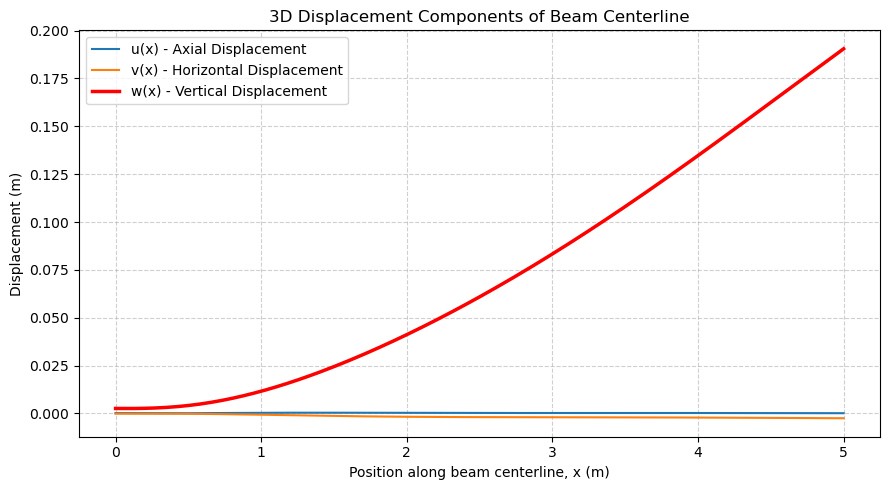

In [5]:
# --- Evaluation and Plotting ---

# 1. Create 3D points along the beam's centerline for evaluation
# We create a line where y and z are at the center of the cross-section.
x_coords_norm = torch.linspace(0, L_norm, 200).view(-1, 1)
y_coords_norm = torch.full_like(x_coords_norm, W_norm / 2)
z_coords_norm = torch.full_like(x_coords_norm, H_norm / 2)
x_eval_3d_norm = torch.cat([x_coords_norm, y_coords_norm, z_coords_norm], dim=1)

# 2. Get the 3D displacement prediction from the model
# The model now outputs a tensor of shape [200, 3] for (u,v,w).
with torch.no_grad():
    displacement_pred_norm = model(x_eval_3d_norm).numpy()

# 3. Un-scale the results to real units for plotting
x_vals_real = x_coords_norm.numpy() * x_scale
# The w_scale applies to all displacement components (u, v, and w).
u_pred_real = displacement_pred_norm[:, 0] * w_scale # First column is u
v_pred_real = displacement_pred_norm[:, 1] * w_scale # Second column is v
w_pred_real = displacement_pred_norm[:, 2] * w_scale # Third column is w

# 4. Plot each displacement component on the same graph
plt.figure(figsize=(9, 5))
plt.plot(x_vals_real, u_pred_real, label="u(x) - Axial Displacement")
plt.plot(x_vals_real, v_pred_real, label="v(x) - Horizontal Displacement")
plt.plot(x_vals_real, w_pred_real, label="w(x) - Vertical Displacement", linewidth=2.5, color='red')

plt.xlabel("Position along beam centerline, x (m)")
plt.ylabel("Displacement (m)")
plt.title("3D Displacement Components of Beam Centerline")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()

Vertical Max Deflection (Analytical): 0.18292419929264175
Vertical Max Deflection (Predicted): 0.19048476219177246


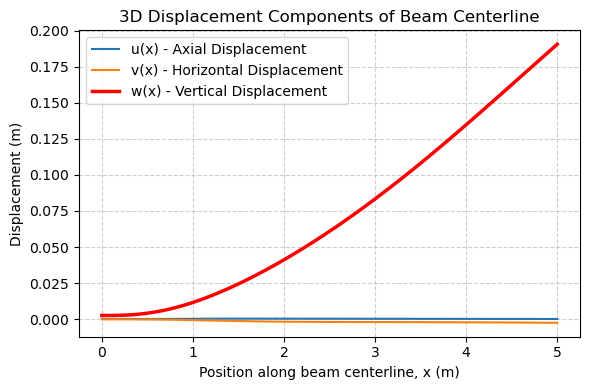

In [6]:
# Max deflection at the tip

max_vertical_deflection = np.max(np.abs(w_pred_real))

force_tip = 500.0         # Force at the tip in Newtons (N)
force_mid = 300.0         # Force at the midpoint in Newtons (N)
length = L_real              # Length of the beam in meters (m)
youngs_modulus = E_real   # Young's Modulus for steel in Pascals (Pa)
width = W_real              # Beam cross-section width in meters (m)
height = H_real             # Beam cross-section height in meters (m)

# 2. Calculate the Moment of Inertia (I)
moment_of_inertia = (width * height**3) / 12.0

# 3. Calculate deflection from the tip load (P1)
deflection_from_tip_load = (force_tip * length**3) / (3 * youngs_modulus * moment_of_inertia)

# 4. Calculate deflection from the midpoint load (P2)
# The formula for max deflection from a load P at position 'a' is: (P*a²*(3L-a))/(6EI)
a = length / 2.0
deflection_from_mid_load = (force_mid * a**2 * (3 * length - a)) / (6 * youngs_modulus * moment_of_inertia)

# 5. Add the deflections together for the total max deflection
total_analytical_deflection = deflection_from_tip_load + deflection_from_mid_load

# 6. Print the final result
print(f"Vertical Max Deflection (Analytical): {total_analytical_deflection}")
print(f"Vertical Max Deflection (Predicted): {max_vertical_deflection}")


plt.figure(figsize=(6, 4))
plt.plot(x_vals_real, u_pred_real, label="u(x) - Axial Displacement")
plt.plot(x_vals_real, v_pred_real, label="v(x) - Horizontal Displacement")
plt.plot(x_vals_real, w_pred_real, label="w(x) - Vertical Displacement", linewidth=2.5, color='red')

plt.xlabel("Position along beam centerline, x (m)")
plt.ylabel("Displacement (m)")
plt.title("3D Displacement Components of Beam Centerline")
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()